In [1]:
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import MobileNet_V2_Weights
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
# from google.colab import drive

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.5125438].


Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


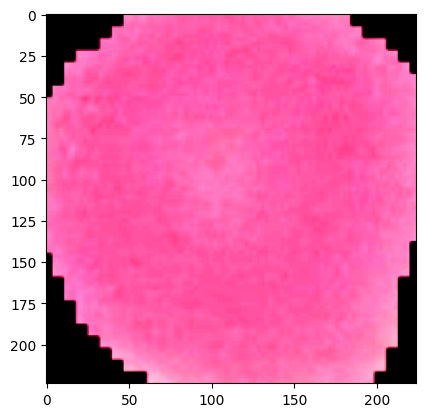

Label: 1 (Uninfected)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

#For ensemble inference, all models were evaluated on a shared test set preprocessed using the MobileNetV2 ImageNet normalization pipeline for consistency
weights = MobileNet_V2_Weights.DEFAULT

test_transform = weights.transforms()

base_dataset = datasets.ImageFolder('malaria_cells_nih')


g = torch.Generator().manual_seed(42)   
train_size = int(0.8 * len(base_dataset))
test_size  = len(base_dataset) - train_size
train_indices, test_indices = torch.utils.data.random_split(range(len(base_dataset)), [train_size, test_size], generator=g)
test_dataset  = datasets.ImageFolder('malaria_cells_nih', transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, sampler=torch.utils.data.SubsetRandomSampler(test_indices.indices))

test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].permute(1, 2, 0)
label = test_labels[0]
plt.imshow(img.numpy())
plt.show()
statement = f"Label: {label} (Parasitized)" if label == 0 else f"Label: {label} (Uninfected)"
print(statement)

In [ ]:
def print_binary_metrics(labels, preds, positive = 0):
    pos = positive
    neg = 1 - positive
    labels = labels.long()
    statement = "Parasitized as Positive Class" if positive == 0 else "Uninfected as Positive Class"
    print(f"========= {statement} =========")
    print("Total samples:", len(labels))


    print("Label counts:", torch.bincount(labels))
    print("Pred counts :", torch.bincount(preds))


    num_correct = (preds == labels).sum().item()
    num_total = len(labels)
    print("Correct:", num_correct, "Wrong:", num_total - num_correct)
    print("Accuracy from raw counts:", num_correct / num_total)
    
    tp = ((preds == pos) & (labels == pos)).sum().item()
    tn = ((preds == neg) & (labels == neg)).sum().item()
    fp = ((preds == pos) & (labels == neg)).sum().item()
    fn = ((preds == neg) & (labels == pos)).sum().item()

    eps = 1e-8  

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    accuracy  = (tp + tn) / (tp + tn + fp + fn + eps)
    print(f"precision: {precision}  recall: {recall}  f1: {f1}  accuracy: {accuracy}")
    print("TP, FP, FN, TN:", tp, fp, fn, tn)

eff = models.efficientnet_b0()
eff_dict = torch.load("model0_best.pt", weights_only=False)
in_features = eff.classifier[1].in_features
eff.classifier[1] = nn.Linear(in_features=in_features, out_features=2, bias=True)
eff.load_state_dict(eff_dict)
eff.to(device)

res = models.resnet18()
res_dict = torch.load("model1_best.pt", weights_only=False)
in_features = res.fc.in_features
res.fc = nn.Linear(in_features=in_features, out_features=2, bias=True)
res.load_state_dict(res_dict)
res.to(device)

mobile = models.mobilenet_v2()
mobile_dict = torch.load("model2_best.pt", weights_only=False)
in_features = mobile.classifier[1].in_features
mobile.classifier[1] = nn.Linear(in_features=in_features, out_features=2, bias=True)
mobile.load_state_dict(mobile_dict)
mobile.to(device)


eff.eval()
res.eval()
mobile.eval()


def ensemble(images):
    eff_probs = torch.softmax(eff(images), dim=1)
    res_probs = torch.softmax(res(images), dim=1)
    mobile_probs = torch.softmax(mobile(images), dim=1)

    return (eff_probs+res_probs+mobile_probs)/3

all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        test = images.to(device)
        labels = labels.to(device)
       

        average = ensemble(test)

        predicted = average.argmax(dim=1)
        all_labels.append(labels)
        all_preds.append(predicted)

all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)

cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())
class_names = ["Parasitized", "Uninfected"] 
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_display.plot()
plt.show()

print_binary_metrics(labels=all_labels, preds=all_preds, positive=0)
print("")
print_binary_metrics(labels=all_labels, preds=all_preds, positive=1)


